In [4]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BusBreakdowns").getOrCreate()

# Read the file 
file = "sampled_data.csv"
df = spark.read.option("header", "true").csv(file)

print(f"Shape of data: ({df.count()}, {len(df.columns)})")
df.printSchema()

Shape of data: (10000, 21)
root
 |-- School_Year: string (nullable = true)
 |-- Busbreakdown_ID: string (nullable = true)
 |-- Run_Type: string (nullable = true)
 |-- Bus_No: string (nullable = true)
 |-- Route_Number: string (nullable = true)
 |-- Reason: string (nullable = true)
 |-- Schools_Serviced: string (nullable = true)
 |-- Occurred_On: string (nullable = true)
 |-- Created_On: string (nullable = true)
 |-- Boro: string (nullable = true)
 |-- Bus_Company_Name: string (nullable = true)
 |-- How_Long_Delayed: string (nullable = true)
 |-- Number_Of_Students_On_The_Bus: string (nullable = true)
 |-- Has_Contractor_Notified_Schools: string (nullable = true)
 |-- Has_Contractor_Notified_Parents: string (nullable = true)
 |-- Have_You_Alerted_OPT: string (nullable = true)
 |-- Informed_On: string (nullable = true)
 |-- Incident_Number: string (nullable = true)
 |-- Last_Updated_On: string (nullable = true)
 |-- Breakdown_or_Running_Late: string (nullable = true)
 |-- School_Age_or_P

In [5]:
from pyspark.sql.functions import when, col
missing_data = df.selectExpr([f'sum(if({c} is null, 1, 0)) as {c}' for c in df.columns])
missing_data.show()

+-----------+---------------+--------+------+------------+------+----------------+-----------+----------+----+----------------+----------------+-----------------------------+-------------------------------+-------------------------------+--------------------+-----------+---------------+---------------+-------------------------+------------------+
|School_Year|Busbreakdown_ID|Run_Type|Bus_No|Route_Number|Reason|Schools_Serviced|Occurred_On|Created_On|Boro|Bus_Company_Name|How_Long_Delayed|Number_Of_Students_On_The_Bus|Has_Contractor_Notified_Schools|Has_Contractor_Notified_Parents|Have_You_Alerted_OPT|Informed_On|Incident_Number|Last_Updated_On|Breakdown_or_Running_Late|School_Age_or_PreK|
+-----------+---------------+--------+------+------------+------+----------------+-----------+----------+----+----------------+----------------+-----------------------------+-------------------------------+-------------------------------+--------------------+-----------+---------------+---------------

In [6]:
from pyspark.sql.functions import when, col
delay_time_category = ['16-30 Min', '31-45 Min', '0-15 Min', '46-60 Min', '61-90 Min']
df = df.filter(df['How_Long_Delayed'].isin(delay_time_category)).withColumn("How_Long_Delayed", when(
    col("How_Long_Delayed").isin(delay_time_category) | col("How_Long_Delayed").isNotNull(), 
    col("How_Long_Delayed")).otherwise("91-Inf Min"))
df.groupBy("How_Long_Delayed").count().show()

columns_to_drop_na = ['Run_Type', 'Reason', 'Boro', 'School_Age_or_PreK']
df = df.dropna(subset=columns_to_drop_na)

missing_data = df.selectExpr([f'sum(if({c} is null, 1, 0)) as {c}' for c in df.columns])
missing_data.show()

+----------------+-----+
|How_Long_Delayed|count|
+----------------+-----+
|        0-15 Min|  967|
|       16-30 Min| 2599|
|       31-45 Min| 3004|
|       46-60 Min| 1732|
|       61-90 Min|  943|
+----------------+-----+

+-----------+---------------+--------+------+------------+------+----------------+-----------+----------+----+----------------+----------------+-----------------------------+-------------------------------+-------------------------------+--------------------+-----------+---------------+---------------+-------------------------+------------------+
|School_Year|Busbreakdown_ID|Run_Type|Bus_No|Route_Number|Reason|Schools_Serviced|Occurred_On|Created_On|Boro|Bus_Company_Name|How_Long_Delayed|Number_Of_Students_On_The_Bus|Has_Contractor_Notified_Schools|Has_Contractor_Notified_Parents|Have_You_Alerted_OPT|Informed_On|Incident_Number|Last_Updated_On|Breakdown_or_Running_Late|School_Age_or_PreK|
+-----------+---------------+--------+------+------------+------+-----------

In [7]:
column_name = 'Number_Of_Students_On_The_Bus'
df.select(column_name).describe().show()

+-------+-----------------------------+
|summary|Number_Of_Students_On_The_Bus|
+-------+-----------------------------+
|  count|                         9243|
|   mean|           3.3417721518987342|
| stddev|            97.23426454195086|
|    min|                            0|
|    max|                         9034|
+-------+-----------------------------+



In [8]:
column_name = 'Number_Of_Students_On_The_Bus'
df.select(column_name).describe().show()
df.filter(df[column_name]<100).select(column_name).describe().show()

+-------+-----------------------------+
|summary|Number_Of_Students_On_The_Bus|
+-------+-----------------------------+
|  count|                         9243|
|   mean|           3.3417721518987342|
| stddev|            97.23426454195086|
|    min|                            0|
|    max|                         9034|
+-------+-----------------------------+

+-------+-----------------------------+
|summary|Number_Of_Students_On_The_Bus|
+-------+-----------------------------+
|  count|                         9237|
|   mean|           1.8448630507740609|
| stddev|            3.701987116836907|
|    min|                            0|
|    max|                            9|
+-------+-----------------------------+



In [11]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

mean_value = df.agg({'Number_Of_Students_On_The_Bus': 'mean'}).collect()[0][0]
stddev_value = df.agg({'Number_Of_Students_On_The_Bus': 'stddev'}).collect()[0][0]

df = df.withColumn('z_scores', (df['Number_Of_Students_On_The_Bus'] - mean_value) / stddev_value)
df = df.filter((df['Number_Of_Students_On_The_Bus'] < 100) & (df['z_scores'] < 5))
df.select(column_name).describe().show()

+-------+-----------------------------+
|summary|Number_Of_Students_On_The_Bus|
+-------+-----------------------------+
|  count|                         9201|
|   mean|            1.732094337572003|
| stddev|           3.1971218806600255|
|    min|                            0|
|    max|                            9|
+-------+-----------------------------+



In [12]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import date_format

df = df.withColumn('Occurred_On', to_timestamp(df['Occurred_On'], 'MM/dd/yyyy hh:mm:ss a'))
df = df.withColumn('Occurred_On', df['Occurred_On'].cast(TimestampType()))
df.select('Occurred_On', date_format('Occurred_On', 'MM/dd/yyyy hh:mm:ss a').alias('Formatted_Occurred_On')).show()

+-------------------+---------------------+
|        Occurred_On|Formatted_Occurred_On|
+-------------------+---------------------+
|2022-10-12 15:22:00| 10/12/2022 03:22:...|
|2023-04-17 14:20:00| 04/17/2023 02:20:...|
|2020-01-24 15:23:00| 01/24/2020 03:23:...|
|2021-10-07 15:20:00| 10/07/2021 03:20:...|
|2018-10-03 07:25:00| 10/03/2018 07:25:...|
|2021-04-08 07:52:00| 04/08/2021 07:52:...|
|2022-10-13 08:20:00| 10/13/2022 08:20:...|
|2022-09-28 06:03:00| 09/28/2022 06:03:...|
|2021-05-28 08:52:00| 05/28/2021 08:52:...|
|2023-05-03 06:45:00| 05/03/2023 06:45:...|
|2022-02-07 07:30:00| 02/07/2022 07:30:...|
|2022-10-06 14:55:00| 10/06/2022 02:55:...|
|2019-12-20 06:43:00| 12/20/2019 06:43:...|
|2022-10-12 09:00:00| 10/12/2022 09:00:...|
|2021-10-15 07:00:00| 10/15/2021 07:00:...|
|2023-02-28 13:33:00| 02/28/2023 01:33:...|
|2019-11-22 07:33:00| 11/22/2019 07:33:...|
|2018-09-12 04:10:00| 09/12/2018 04:10:...|
|2023-03-16 05:20:00| 03/16/2023 05:20:...|
|2021-11-22 07:01:00| 11/22/2021

In [13]:
from pyspark.sql.functions import hour, dayofweek, month
import matplotlib.pyplot as plt

# Derive new columns
df = df.withColumn("Occurred_On_Hour", hour("Occurred_On"))
df = df.withColumn("Occurred_On_DayOfWeek", (dayofweek("Occurred_On") - 1).cast("integer"))
df = df.withColumn("Occurred_On_Month", month("Occurred_On"))

+----------------+-----+
|Occurred_On_Hour|Count|
+----------------+-----+
|               0|   20|
|               1|   11|
|               2|   20|
|               3|    8|
|               4|    4|
|               5|  355|
|               6| 2839|
|               7| 3132|
|               8|  748|
|               9|   62|
|              10|   14|
|              11|   21|
|              12|   59|
|              13|  799|
|              14|  811|
|              15|  244|
|              16|   42|
|              17|   12|
+----------------+-----+



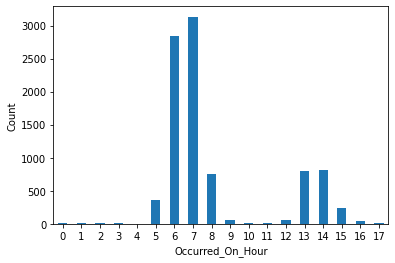

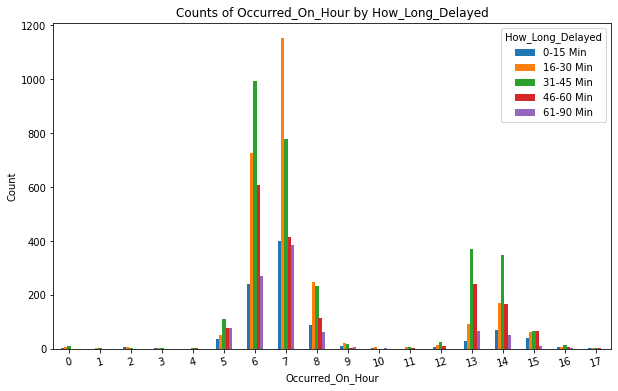

+---------------------+-----+
|Occurred_On_DayOfWeek|Count|
+---------------------+-----+
|                    1| 1827|
|                    2| 1862|
|                    3| 1881|
|                    4| 1869|
|                    5| 1762|
+---------------------+-----+



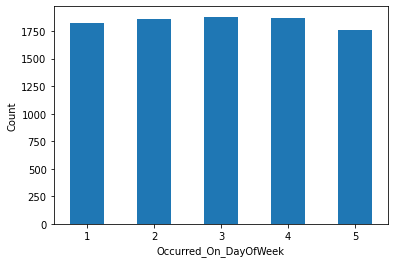

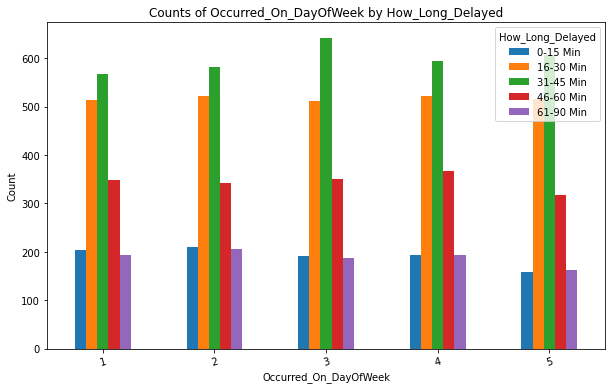

+-----------------+-----+
|Occurred_On_Month|Count|
+-----------------+-----+
|                1| 1015|
|                2|  861|
|                3|  966|
|                4|  634|
|                5|  884|
|                6|  489|
|                9|  863|
|               10| 1401|
|               11| 1196|
|               12|  892|
+-----------------+-----+



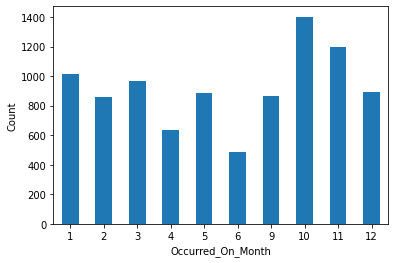

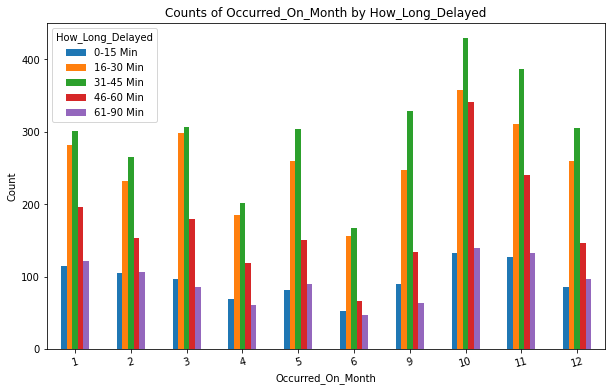

In [14]:
# Visualize the data
colname_time_new = ['Occurred_On_Hour', 'Occurred_On_DayOfWeek', 'Occurred_On_Month']
df.createOrReplaceTempView("bus_data")
for item in colname_time_new:
    result = spark.sql(f"SELECT {item}, COUNT(*) AS Count FROM bus_data GROUP BY {item} ORDER BY {item}")
    result.show()
    
    data = result.toPandas()
    data.plot(kind='bar', x=item, y='Count', legend=False)
    plt.ylabel('Count')
    plt.xlabel(item)
    plt.xticks(rotation=0)
    plt.show()
    
    data = df.groupBy(item, 'How_Long_Delayed').count().orderBy('How_Long_Delayed')
    pivot_df = data.toPandas().pivot(index=item, columns='How_Long_Delayed', values='count')
    pivot_df.plot(kind='bar', figsize=(10, 6))
    plt.ylabel('Count')
    plt.xlabel(item)
    plt.xticks(rotation=15)
    plt.title(f'Counts of {item} by How_Long_Delayed')
    plt.show()

In [15]:
from pyspark.sql.types import IntegerType
df = df.withColumn("Number_Of_Students_On_The_Bus", df["Number_Of_Students_On_The_Bus"].cast(IntegerType()))
# Select specific columns
selected_columns = ['School_Year', 'Run_Type', 'Reason', 'Boro', 'Bus_Company_Name',
                    'School_Age_or_PreK', 'Number_Of_Students_On_The_Bus', 'Occurred_On_Hour',
                    'Occurred_On_Month', 'How_Long_Delayed', 'Has_Contractor_Notified_Schools',
                    'Has_Contractor_Notified_Parents', 'Have_You_Alerted_OPT']

df = df.select(selected_columns)

# Show DataFrame info
df.printSchema()

# Save the DataFrame to a CSV file
df.write.csv('cleaned.csv', header=True, mode='overwrite')

root
 |-- School_Year: string (nullable = true)
 |-- Run_Type: string (nullable = true)
 |-- Reason: string (nullable = true)
 |-- Boro: string (nullable = true)
 |-- Bus_Company_Name: string (nullable = true)
 |-- School_Age_or_PreK: string (nullable = true)
 |-- Number_Of_Students_On_The_Bus: integer (nullable = true)
 |-- Occurred_On_Hour: integer (nullable = true)
 |-- Occurred_On_Month: integer (nullable = true)
 |-- How_Long_Delayed: string (nullable = true)
 |-- Has_Contractor_Notified_Schools: string (nullable = true)
 |-- Has_Contractor_Notified_Parents: string (nullable = true)
 |-- Have_You_Alerted_OPT: string (nullable = true)



In [27]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BusBreakdowns").getOrCreate()

# Read the file 
file = "cleaned.csv"
df = spark.read.option("header", "true").csv(file)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import when, log
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F


df = df.withColumn('How_Long_Delayed', when(df['How_Long_Delayed'] == '0-15 Min', 15)
                                   .when(df['How_Long_Delayed'] == '16-30 Min', 30)
                                   .when(df['How_Long_Delayed'] == '31-45 Min', 45)
                                   .when(df['How_Long_Delayed'] == '46-60 Min', 60)
                                   .when(df['How_Long_Delayed'] == '61-90 Min', 90)
                                   .when(df['How_Long_Delayed'] == '91-Inf Min', 360)
                                   .otherwise(df['How_Long_Delayed']).cast(DoubleType()))

+-------+-----------------+
|summary| How_Long_Delayed|
+-------+-----------------+
|  count|             9201|
|   mean|45.08151287903489|
| stddev|20.15116477737358|
|    min|             15.0|
|    max|             90.0|
+-------+-----------------+



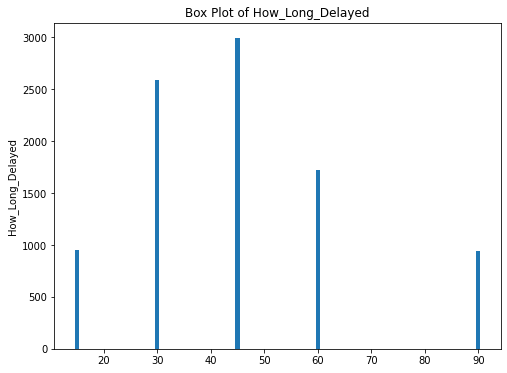

In [9]:
df.select('How_Long_Delayed').describe().show()

counts = df.groupBy('How_Long_Delayed').agg(F.count('*').alias('Count'))
counts_pandas = counts.toPandas()
plt.figure(figsize=(8, 6))
plt.bar(counts_pandas['How_Long_Delayed'], counts_pandas['Count'])
plt.ylabel('How_Long_Delayed')
plt.title('Box Plot of How_Long_Delayed')
plt.show()

In [4]:
df = df.withColumn('How_Long_Delayed', log(df['How_Long_Delayed']))

+-------+------------------+
|summary|  How_Long_Delayed|
+-------+------------------+
|  count|              9201|
|   mean| 3.703379906828375|
| stddev|0.4749949512108136|
|    min|  2.70805020110221|
|    max| 4.499809670330265|
+-------+------------------+



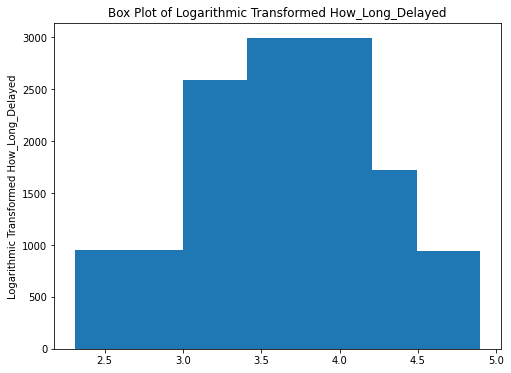

In [11]:
df.select('How_Long_Delayed').describe().show()

counts = df.groupBy('How_Long_Delayed').agg(F.count('*').alias('Count'))
counts_pandas = counts.toPandas()
plt.figure(figsize=(8, 6))
plt.bar(counts_pandas['How_Long_Delayed'], counts_pandas['Count'])
plt.ylabel('Logarithmic Transformed How_Long_Delayed')
plt.title('Box Plot of Logarithmic Transformed How_Long_Delayed')
plt.show()

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql import SparkSession

# List of categorical columns
categorical_columns = ['School_Year', 'Run_Type', 'Reason', 'Boro','Number_Of_Students_On_The_Bus', 'Occurred_On_Hour', 'Occurred_On_Month',
                       'Bus_Company_Name', 'School_Age_or_PreK',
                       'Has_Contractor_Notified_Schools', 'Has_Contractor_Notified_Parents',
                       'Have_You_Alerted_OPT']

stages = []

for col in categorical_columns:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep")
    encoder = OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded")
    stages += [indexer, encoder]

from pyspark.ml import Pipeline

pipeline = Pipeline(stages=stages)
model = pipeline.fit(df)
df = model.transform(df)

In [13]:
# Define the target column
target_column = 'How_Long_Delayed'

# Define a list of groups of features
feature_groups = [
    ['School_Year_encoded', 'Number_Of_Students_On_The_Bus_encoded', 'Occurred_On_Hour_encoded', 'Occurred_On_Month_encoded'],
    ['Run_Type_encoded', 'Reason_encoded', 'Boro_encoded', 'Bus_Company_Name_encoded'],
    ['School_Age_or_PreK_encoded', 'Has_Contractor_Notified_Schools_encoded', 'Has_Contractor_Notified_Parents_encoded', 'Have_You_Alerted_OPT_encoded']
]

for i, group in enumerate(feature_groups):
    sub_df = df.select(group + [target_column])

    feature_assembler = VectorAssembler(inputCols=group, outputCol="features")
    sub_df = feature_assembler.transform(sub_df)

    lr = LinearRegression(featuresCol="features", labelCol=target_column)
    lr_model = lr.fit(sub_df)

    evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(lr_model.transform(sub_df))
    r2 = evaluator.evaluate(lr_model.transform(sub_df), {evaluator.metricName: "r2"})

    print(f"Model for group {i + 1} features:")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2): {r2}\n")  

23/10/12 17:53:45 WARN Instrumentation: [4111d975] regParam is zero, which might cause numerical instability and overfitting.
23/10/12 17:53:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/12 17:53:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/10/12 17:53:47 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/10/12 17:53:47 WARN Instrumentation: [4111d975] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Model for group 1 features:
Root Mean Squared Error (RMSE): 0.455825014899164
R-squared (R2): 0.07898749660487492



23/10/12 17:53:51 WARN Instrumentation: [ab7efe63] regParam is zero, which might cause numerical instability and overfitting.
23/10/12 17:53:51 WARN Instrumentation: [ab7efe63] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Model for group 2 features:
Root Mean Squared Error (RMSE): 0.3472469367823476
R-squared (R2): 0.4655020263741063



23/10/12 17:53:53 WARN Instrumentation: [2554234c] regParam is zero, which might cause numerical instability and overfitting.
23/10/12 17:53:54 WARN Instrumentation: [2554234c] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Model for group 3 features:
Root Mean Squared Error (RMSE): 0.46754756874053943
R-squared (R2): 0.031006592396392807



In [6]:
target_column = 'How_Long_Delayed'

group = ['Run_Type_encoded', 'Reason_encoded', 'Boro_encoded', 'Bus_Company_Name_encoded']
    

sub_df = df.select(group + [target_column])
feature_assembler = VectorAssembler(inputCols=group, outputCol="features")
sub_df = feature_assembler.transform(sub_df)

sub_df.printSchema()
sub_df.show()

root
 |-- Run_Type_encoded: vector (nullable = true)
 |-- Reason_encoded: vector (nullable = true)
 |-- Boro_encoded: vector (nullable = true)
 |-- Bus_Company_Name_encoded: vector (nullable = true)
 |-- How_Long_Delayed: double (nullable = true)
 |-- features: vector (nullable = true)

+----------------+--------------+--------------+------------------------+------------------+--------------------+
|Run_Type_encoded|Reason_encoded|  Boro_encoded|Bus_Company_Name_encoded|  How_Long_Delayed|            features|
+----------------+--------------+--------------+------------------------+------------------+--------------------+
|   (8,[1],[1.0])|(10,[0],[1.0])|(11,[4],[1.0])|          (64,[1],[1.0])|3.8066624897703196|(93,[1,8,22,30],[...|
|   (8,[4],[1.0])|(10,[1],[1.0])|(11,[2],[1.0])|         (64,[25],[1.0])|   4.0943445622221|(93,[4,9,20,54],[...|
|   (8,[4],[1.0])|(10,[0],[1.0])|(11,[2],[1.0])|          (64,[1],[1.0])|  2.70805020110221|(93,[4,8,20,30],[...|
|   (8,[3],[1.0])|(10,[1],[1

In [24]:
df.select('Run_Type','Run_Type_encoded').distinct().show()

+--------------------+----------------+
|            Run_Type|Run_Type_encoded|
+--------------------+----------------+
|   General Ed AM Run|   (8,[2],[1.0])|
|General Ed Field ...|   (8,[5],[1.0])|
|            Pre-K/EI|   (8,[3],[1.0])|
|Special Ed Field ...|   (8,[6],[1.0])|
|   General Ed PM Run|   (8,[4],[1.0])|
|   Special Ed PM Run|   (8,[1],[1.0])|
| Project Read PM Run|   (8,[7],[1.0])|
|   Special Ed AM Run|   (8,[0],[1.0])|
+--------------------+----------------+



In [25]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.sql.functions import col

training, test = sub_df.randomSplit([0.7, 0.3])

lr = LinearRegression(featuresCol='features', labelCol='How_Long_Delayed', predictionCol='prediction')

# Fit themodel
lrModel = lr.fit(training)


print("Coefficients: {}".format(str(lrModel.coefficients))) 
print('\n')
print("Intercept:{}".format(str(lrModel.intercept)))

trainingSummary = lrModel.summary
trainingSummary.residuals.show()

# Print Root Mean Squared Error. 
print("RMSE: {}".format(trainingSummary.rootMeanSquaredError))

# Print R-Squared.
print("r2: {}".format(trainingSummary.r2))

23/10/12 19:36:06 WARN Instrumentation: [5a25564c] regParam is zero, which might cause numerical instability and overfitting.
23/10/12 19:36:07 WARN Instrumentation: [5a25564c] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Coefficients: [0.01686754122593548,-0.0011958487775275085,-0.06895704402694795,0.030502902069591737,-0.02352522998725408,0.12568265399850712,0.08912838857503205,-0.06529623493674518,-0.10700306581166329,0.06284300643228198,0.13178711732716095,0.08741999194334593,-0.060951356446665175,0.01128790750517912,0.10174325375188208,0.16285318214834812,0.3590800632946508,-0.027511863807429048,-0.0011050692457408066,-0.01361152554684809,-0.11724021893580336,0.008980748546527029,0.4838056726169224,0.004350127355022493,-0.0702538268776614,-0.012947073025969267,0.0727787110078322,0.1683186095633346,-0.13537639814122424,0.2833573126423967,-0.3286909102690554,0.09109131575519203,-0.13207311618336284,0.4587066927725497,-0.6144460301074904,0.1184032700252837,-0.4035805307753427,-0.07596497524722597,-0.1981339103991322,-0.2363488745823,-0.029986232181148764,-0.26250369039146393,0.34604218982625584,-0.2093343932540896,0.9277903575127866,0.35423766774233967,-0.0059525409372933515,-0.030815089842799053,-0.2

In [9]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.sql.functions import col


# Select columns for the GLM model
glm_data = df.select(group)

# Create a GLM model
glm = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="How_Long_Delayed",
    family="gaussian",
    link="identity",
    maxIter=10,
    regParam=0.3
)

# Fit the GLM model
glm_model = glm.fit(sub_df)

# View the summary of the GLM model
summary = glm_model.summary

# Get the coefficients and p-values for each feature
p_values = summary.coefficientStandardErrors


# Display coefficients and p-values
for feature,  p_value in zip(group,  p_values):
    print(f"Feature: {feature}")
    print(f"P-value: {p_value}\n")


Feature: Run_Type_encoded
P-value: 0.007775680841645354

Feature: Reason_encoded
P-value: 0.009664343370718082

Feature: Boro_encoded
P-value: 0.011410271496121985

Feature: Bus_Company_Name_encoded
P-value: 0.012730706743041368



In [12]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

train_data, test_data = sub_df.randomSplit([0.7, 0.3])
dt = DecisionTreeRegressor(featuresCol="features", labelCol="How_Long_Delayed")
dt_model = dt.fit(train_data)
predictions = dt_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Root Mean Squared Error (RMSE): 0.3978081599896161
R-squared (R2): 0.31514242188297126


In [13]:
feature_importances = dt_model.featureImportances
feature_names = train_data.columns[:-1]  # Exclude the target column
importance_scores = feature_importances.toArray().tolist()

feature_importance_list = [(feature, importance) for feature, importance in zip(feature_names, importance_scores)]

# Sort the features by importance (optional)
feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

for feature, importance in feature_importance_list:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: Run_Type_encoded, Importance: 0.003231527818529632
Feature: Reason_encoded, Importance: 0.0005459857890047265
Feature: Boro_encoded, Importance: 0.0
Feature: Bus_Company_Name_encoded, Importance: 0.0
Feature: How_Long_Delayed, Importance: 0.0


In [29]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BusBreakdowns").getOrCreate()

# Read the file 
file = "cleaned.csv"
df = spark.read.option("header", "true").csv(file)

In [32]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

target_column = 'How_Long_Delayed'
group = ['Run_Type_encoded', 'Reason_encoded', 'Boro_encoded', 'Bus_Company_Name_encoded']

df = df.withColumn('How_Long_Delayed', when(df['How_Long_Delayed'] > 45, 1)
                                  .when(df['How_Long_Delayed'] <= 45, 0))

# Create StringIndexers for categorical predictor variables
Run_Type_indexer = StringIndexer(inputCol="Run_Type", outputCol="Run_Type_index")
Reason_indexer = StringIndexer(inputCol="Reason", outputCol="Reason_index")
Boro_indexer = StringIndexer(inputCol="Boro", outputCol="Boro_index")
Bus_Company_Name_indexer = StringIndexer(inputCol="Bus_Company_Name", outputCol="Bus_Company_Name_index")

# Create a StringIndexer for the target variable
target_indexer = StringIndexer(inputCol="How_Long_Delayed", outputCol="label")

# Assemble the predictor variables into a single features column
assembler = VectorAssembler(
    inputCols=["Run_Type_index","Reason_index", "Boro_index","Bus_Company_Name_index"],
    outputCol="features"
)

# Define a pipeline to execute the transformations
pipeline = Pipeline(stages=[Run_Type_indexer, Reason_indexer, Boro_indexer, Bus_Company_Name_indexer, target_indexer, assembler])

# Fit and transform the data using the pipeline
model = pipeline.fit(df)
data = model.transform(df)


final_df = data.select("label", "features")
final_df.show()

+-----+------------------+
|label|          features|
+-----+------------------+
|  0.0| [1.0,0.0,4.0,1.0]|
|  1.0|[4.0,1.0,2.0,25.0]|
|  0.0| [4.0,0.0,2.0,1.0]|
|  1.0|[3.0,1.0,1.0,11.0]|
|  1.0|         (4,[],[])|
|  0.0|[0.0,0.0,2.0,22.0]|
|  1.0|         (4,[],[])|
|  0.0| [0.0,0.0,1.0,6.0]|
|  0.0|[0.0,0.0,1.0,23.0]|
|  0.0|[0.0,0.0,1.0,10.0]|
|  0.0| [2.0,0.0,4.0,1.0]|
|  0.0| [1.0,0.0,6.0,7.0]|
|  0.0|[0.0,0.0,1.0,20.0]|
|  0.0|[2.0,8.0,2.0,25.0]|
|  0.0|[0.0,0.0,2.0,19.0]|
|  1.0|[1.0,1.0,3.0,16.0]|
|  0.0|         (4,[],[])|
|  0.0|[2.0,0.0,2.0,37.0]|
|  1.0| [0.0,0.0,1.0,4.0]|
|  0.0| [0.0,0.0,2.0,4.0]|
+-----+------------------+
only showing top 20 rows



In [33]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LinearSVC,LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = final_df.randomSplit([0.7, 0.3])

# List of models
models = {
    "Support Vector Machines": LinearSVC(featuresCol="features", labelCol="label"),
    "LogisticRegression": LogisticRegression(featuresCol="features", labelCol="label")
}

# Train and evaluate each model
for model_name, model in models.items():
    trained_model = model.fit(train_data)
    predictions = trained_model.transform(test_data)
    
   # Calculate AUC
    binary_evaluator = BinaryClassificationEvaluator()
    auc = binary_evaluator.evaluate(predictions)
    
    # Calculate Accuracy
    multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = multiclass_evaluator.evaluate(predictions)
    
    print(f"{model_name} AUC: {auc}")
    print(f"{model_name} Accuracy: {accuracy}")

23/10/12 21:15:22 WARN BlockManager: Asked to remove block broadcast_659, which does not exist


Support Vector Machines AUC: 0.5644765204617671
Support Vector Machines Accuracy: 0.7072727272727273


LogisticRegression AUC: 0.5668980823580129
LogisticRegression Accuracy: 0.7065454545454546


In [7]:
sub_df.show()

+----------------+--------------+--------------+------------------------+------------------+--------------------+
|Run_Type_encoded|Reason_encoded|  Boro_encoded|Bus_Company_Name_encoded|  How_Long_Delayed|            features|
+----------------+--------------+--------------+------------------------+------------------+--------------------+
|   (8,[1],[1.0])|(10,[0],[1.0])|(11,[4],[1.0])|          (64,[1],[1.0])|3.8066624897703196|(93,[1,8,22,30],[...|
|   (8,[4],[1.0])|(10,[1],[1.0])|(11,[2],[1.0])|         (64,[25],[1.0])|   4.0943445622221|(93,[4,9,20,54],[...|
|   (8,[4],[1.0])|(10,[0],[1.0])|(11,[2],[1.0])|          (64,[1],[1.0])|  2.70805020110221|(93,[4,8,20,30],[...|
|   (8,[3],[1.0])|(10,[1],[1.0])|(11,[1],[1.0])|         (64,[11],[1.0])| 4.499809670330265|(93,[3,9,19,40],[...|
|   (8,[0],[1.0])|(10,[0],[1.0])|(11,[0],[1.0])|          (64,[0],[1.0])|   4.0943445622221|(93,[0,8,18,29],[...|
|   (8,[0],[1.0])|(10,[0],[1.0])|(11,[2],[1.0])|         (64,[22],[1.0])|3.4011973816621

In [7]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

training, test = sub_df.randomSplit([0.7, 0.3])

# Define your regression model
lr = LinearRegression(featuresCol='features', labelCol='How_Long_Delayed', predictionCol='prediction')

# Create a grid of hyperparameters to search
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define an evaluator
evaluator = RegressionEvaluator(
    labelCol='How_Long_Delayed',
    predictionCol='prediction',
    metricName='rmse' 
)

# Create a k-fold CrossValidator
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5  
)

# Fit the CrossValidator to the training data
cvModel = crossval.fit(training)

# Get the best model from cross-validation
best_model = cvModel.bestModel

# View the best hyperparameters
print("Best RegParam: ", best_model._java_obj.getRegParam())
print("Best ElasticNetParam: ", best_model._java_obj.getElasticNetParam())

# Evaluate the best model on the test set
test_predictions = best_model.transform(test)
test_rmse = evaluator.evaluate(test_predictions)
print("RMSE on test data: ", test_rmse)


23/10/13 01:44:54 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/13 01:44:54 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/10/13 01:44:54 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Best RegParam:  0.01
Best ElasticNetParam:  0.5


RMSE on test data:  0.34658159288273


In [7]:
import ast

training, test = sub_df.randomSplit([0.85, 0.15])
reg_param = 0.01
elastic_net_param = 0.0

lr = LinearRegression(featuresCol='features', labelCol='How_Long_Delayed', predictionCol='prediction',
                      regParam=reg_param, elasticNetParam=elastic_net_param)

lrModel = lr.fit(training)
predictions = lrModel.transform(test)

coefficients = lrModel.coefficients

intercept = lrModel.intercept
model_summary = lrModel.summary

rmse = model_summary.rootMeanSquaredError

r2 = model_summary.r2

# Display results
print("Feature Coefficients")
coefficients = ast.literal_eval(str(lrModel.coefficients))
pValues = ast.literal_eval(str(model_summary.pValues))
cnt=0
for i, feature_col in enumerate(df.select('Run_Type','Run_Type_encoded').distinct().collect()):
    coefficient = coefficients[cnt+i]
    pValue = pValues[cnt+i]
    cnt += 1
    print(f"{feature_col}: {coefficient}, {pValue}")
print('\n')
for i, feature_col in enumerate(df.select('Reason','Reason_encoded').distinct().collect()):
    coefficient = coefficients[cnt+i]
    pValue = pValues[cnt+i]
    cnt += 1
    print(f"{feature_col}: {coefficient}, {pValue}")
print('\n')
for i, feature_col in enumerate(df.select('Boro','Boro_encoded').distinct().collect()):
    if i < 10:
        coefficient = coefficients[cnt+i]
        pValue = pValues[cnt+i]
        print(f"{feature_col}: {coefficient}, {pValue}")
    cnt += 1
print('\n')
for i, feature_col in enumerate(df.select('Bus_Company_Name','Bus_Company_Name_encoded').distinct().collect()):
    if i < 10:
        coefficient = coefficients[cnt+i]
        pValue = pValues[cnt+i]
        print(f"{feature_col}: {coefficient}, {pValue}")
    cnt += 1
print('\n')

print("\nModel Intercept (Bias):", intercept)

print(f"\nRoot Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

23/10/13 01:49:55 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/13 01:49:55 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/10/13 01:49:55 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Feature Coefficients
Row(Run_Type='General Ed AM Run', Run_Type_encoded=SparseVector(8, {2: 1.0})): 0.013385446871170971, 0.7187261228034478
Row(Run_Type='General Ed Field Trip', Run_Type_encoded=SparseVector(8, {5: 1.0})): -0.059020604453423574, 0.13773210721781393
Row(Run_Type='Pre-K/EI', Run_Type_encoded=SparseVector(8, {3: 1.0})): -0.015208736115761276, 0.732479307379422
Row(Run_Type='Special Ed Field Trip', Run_Type_encoded=SparseVector(8, {6: 1.0})): 0.04122741813129261, 0.6724242749316547
Row(Run_Type='General Ed PM Run', Run_Type_encoded=SparseVector(8, {4: 1.0})): -0.09777323402557615, 0.01201958703979944
Row(Run_Type='Special Ed PM Run', Run_Type_encoded=SparseVector(8, {1: 1.0})): 0.12515443994008102, 0.002898884080858366
Row(Run_Type='Project Read PM Run', Run_Type_encoded=SparseVector(8, {7: 1.0})): -0.059737534617445326, 0.23620969164062555
Row(Run_Type='Special Ed AM Run', Run_Type_encoded=SparseVector(8, {0: 1.0})): 0.06860492646508302, 0.20636623392908127


Row(Reason=

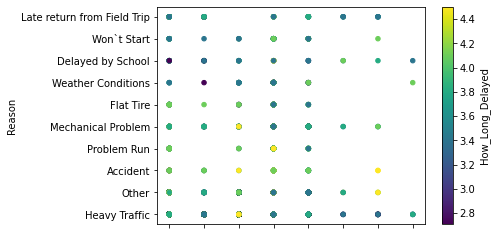

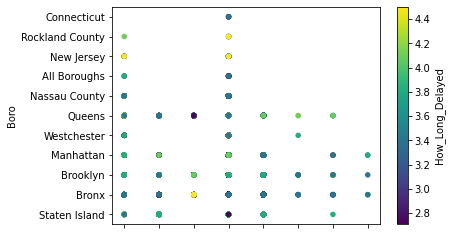

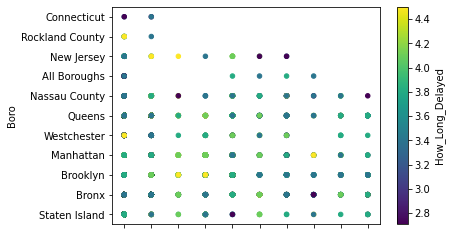

In [23]:
import matplotlib.pyplot as plt

df2 = df.toPandas()
# Visualise the delay time against the predictor variables
df2.plot.scatter(x='Run_Type', y='Reason', c='How_Long_Delayed', colormap='viridis')
df2.plot.scatter(x='Run_Type', y='Boro', c='How_Long_Delayed', colormap='viridis')
df2.plot.scatter(x='Reason', y='Boro', c='How_Long_Delayed', colormap='viridis')
plt.xticks(rotation=15)
plt.show()

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


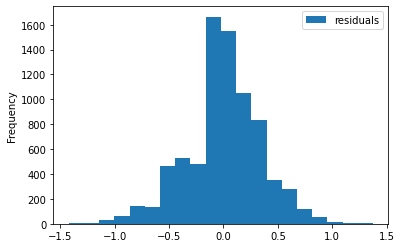

In [8]:
# Extract the residuals
residuals = model_summary.residuals.toPandas()
residuals.plot.hist(bins=20)
plt.show()

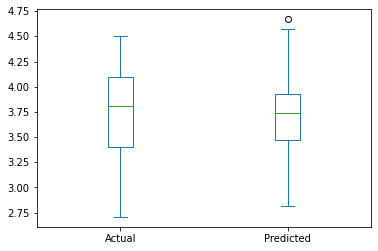

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
predictions = predictions.toPandas()

boxplot = pd.DataFrame({'Actual': predictions['How_Long_Delayed'], 'Predicted': predictions['prediction']})
boxplot.plot.box()
plt.show()

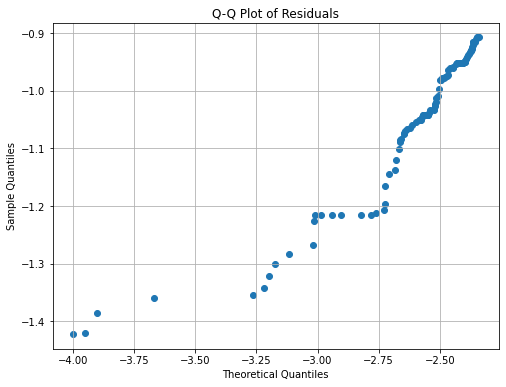

In [25]:
import matplotlib.pyplot as plt
import numpy as np

residuals2 = np.array([residuals])

quantile_levels = [i / 100.0 for i in range(101)]

# Compute the quantiles of the residuals
quantiles = np.percentile(residuals2, quantile_levels)

# Plot the Q-Q plot
plt.figure(figsize=(8, 6))
plt.scatter(np.percentile(np.random.normal(0, 1, len(residuals)), quantile_levels), quantiles)
plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

target_column = 'How_Long_Delayed'
group = ['Run_Type_encoded', 'Reason_encoded', 'Buro_encoded', 'Bus_Company_Name_encoded']

df = df.withColumn('How_Long_Delayed', when(df['How_Long_Delayed'] > 45, 1)
                                 .when(df['How_Long_Delayed'] <= 45, 0))

# Create StringIndexers for categorical predictor variables
Run_Type_indexer = StringIndexer(inputCol="Run_Type", outputCol="Run_Type_index")
Reason_indexer = StringIndexer(inputCol="Reason", outputCol="Reason_index")
Buro_indexer = StringIndexer(inputCol="Buro", outputCol="Buro_index")

# Create a StringIndexer for the target variable
target_indexer = StringIndexer(inputCol="How_Long_Delayed", outputCol="label")

# Assemble the predictor variables into a single features column
assembler = VectorAssembler(
    inputCols=["Run_Type_index","Reason_index" ,"Buro_index"],
    outputCol="features"
)

# Define a pipeline to execute the transformations
pipeline = Pipeline(stages=[Run_Type_indexer, Reason_indexer, Buro_indexer, target_indexer, assembler])

# Fit and transform the data using the pipeline
model = pipeline.fit(df)
data = model.transform(df)

final_df = data.select("label", "features")



In [21]:
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

train_data, test_data = final_df.randomSplit([0.7, 0.3])

lgr = LogisticRegression(featuresCol="features", labelCol="label")

trained_model = lgr.fit(train_data)
predictions = trained_model.transform(test_data)
    

binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(predictions)
    
# Calculate Accuracy
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = multiclass_evaluator.evaluate(predictions)
    
print(f"AUC: {auc}")
print(f"Accuracy: {accuracy}")
    
  

AUC: 0.5644752156701939
Accuracy: 0.7047101449275363


In [29]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

target_column = 'How_Long_Delayed'
group = ['Run_Type_encoded', 'Reason_encoded', 'Boro_encoded', 'Bus_Company_Name_encoded']

df = df.withColumn('How_Long_Delayed', when(df['How_Long_Delayed'] > 30, 1)
                                  .when(df['How_Long_Delayed'] <= 30, 0))

# Create StringIndexers for categorical predictor variables
Run_Type_indexer = StringIndexer(inputCol="Run_Type", outputCol="Run_Type_index")
Reason_indexer = StringIndexer(inputCol="Reason", outputCol="Reason_index")
Boro_indexer = StringIndexer(inputCol="Boro", outputCol="Boro_index")
Bus_Company_Name_indexer = StringIndexer(inputCol="Bus_Company_Name", outputCol="Bus_Company_Name_index")

# Create a StringIndexer for the target variable
target_indexer = StringIndexer(inputCol="How_Long_Delayed", outputCol="label")

# Assemble the predictor variables into a single features column
assembler = VectorAssembler(
    inputCols=["Run_Type_index","Reason_index", "Boro_index","Bus_Company_Name_index"],
    outputCol="features"
)

# Define a pipeline to execute the transformations
pipeline = Pipeline(stages=[Run_Type_indexer, Reason_indexer, Boro_indexer, Bus_Company_Name_indexer, target_indexer, assembler])

# Fit and transform the data using the pipeline
model = pipeline.fit(df)
data = model.transform(df)


final_df = data.select("label", "features")
final_df.show()

+-----+------------------+
|label|          features|
+-----+------------------+
|  0.0| [1.0,0.0,4.0,1.0]|
|  0.0|[4.0,1.0,2.0,25.0]|
|  1.0| [4.0,0.0,2.0,1.0]|
|  0.0|[3.0,1.0,1.0,11.0]|
|  0.0|         (4,[],[])|
|  1.0|[0.0,0.0,2.0,22.0]|
|  0.0|         (4,[],[])|
|  0.0| [0.0,0.0,1.0,6.0]|
|  1.0|[0.0,0.0,1.0,23.0]|
|  1.0|[0.0,0.0,1.0,10.0]|
|  0.0| [2.0,0.0,4.0,1.0]|
|  1.0| [1.0,0.0,6.0,7.0]|
|  1.0|[0.0,0.0,1.0,20.0]|
|  1.0|[2.0,8.0,2.0,25.0]|
|  1.0|[0.0,0.0,2.0,19.0]|
|  0.0|[1.0,1.0,3.0,16.0]|
|  0.0|         (4,[],[])|
|  0.0|[2.0,0.0,2.0,37.0]|
|  0.0| [0.0,0.0,1.0,4.0]|
|  0.0| [0.0,0.0,2.0,4.0]|
+-----+------------------+
only showing top 20 rows



In [30]:
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

train_data, test_data = final_df.randomSplit([0.7, 0.3])

lgr = LogisticRegression(featuresCol="features", labelCol="label")

trained_model = lgr.fit(train_data)
predictions = trained_model.transform(test_data)
    

binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(predictions)
    
# Calculate Accuracy
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = multiclass_evaluator.evaluate(predictions)
    
print(f"AUC: {auc}")
print(f"Accuracy: {accuracy}")

AUC: 0.616349467935925
Accuracy: 0.5799035965888024
